In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Projet COVID X-Ray Classification avec VGG16

## Contexte
Ce projet vise à classifier des radiographies thoraciques en trois catégories :
- **COVID-19**
- **Normal**
- **Viral Pneumonia**

L'objectif est de développer un modèle performant utilisant **Transfer Learning** avec VGG16 pour aider à la détection rapide de COVID-19 à partir d'images médicales.

## Données
- Dataset Chest X-Ray avec répertoires `train`, `val` et `test`.
- Les images sont prétraitées et normalisées pour l'entraînement du modèle.


In [ ]:
train_dir = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train"
val_dir   = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val"
test_dir  = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test"


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
import os

# 🔹 Chemins des dossiers
train_dir = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train"
val_dir   = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val"
test_dir  = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test"

def count_images_per_class(directory):
    print(f"\n Répartition des images dans {directory}:")
    total = 0
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            n_images = len(os.listdir(class_path))
            total += n_images
            print(f"  - {class_name} : {n_images} images")
    print(f"Total images : {total}\n")

# 🔹 Affichage du nombre d'images
count_images_per_class(train_dir)
count_images_per_class(val_dir)
count_images_per_class(test_dir)



📁 Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train:
  - COVID : 3301 images
  - Normal : 7134 images
  - Viral Pneumonia : 941 images
Total images : 11376


📁 Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val:
  - COVID : 1195 images
  - Normal : 2038 images
  - Viral Pneumonia : 269 images
Total images : 3502


📁 Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test:
  - COVID : 362 images
  - Normal : 1020 images
  - Viral Pneumonia : 135 images
Total images : 1517



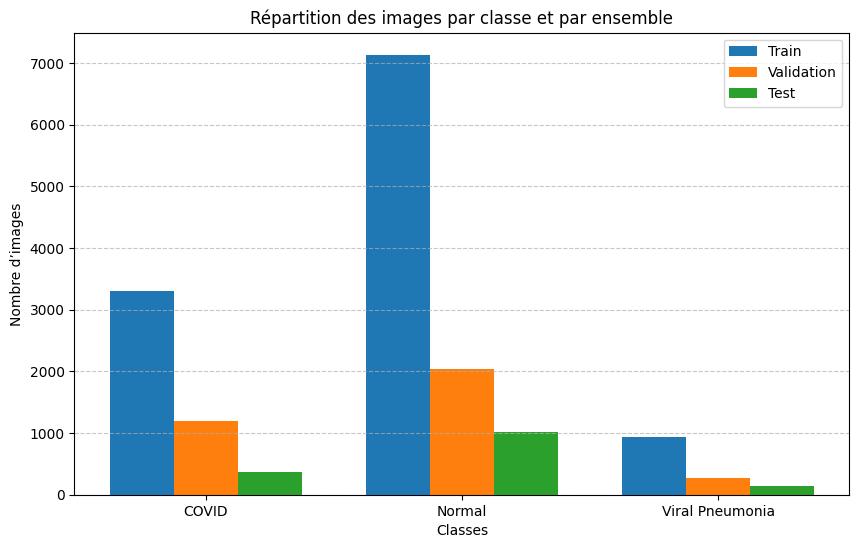

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Données
classes = ['COVID', 'Normal', 'Viral Pneumonia']
train_counts = [3301, 7134, 941]
val_counts = [1195, 2038, 269]
test_counts = [362, 1020, 135]

x = np.arange(len(classes))  # positions des classes
width = 0.25  # largeur des barres

plt.figure(figsize=(10,6))
plt.bar(x - width, train_counts, width, label='Train', color='#1f77b4')
plt.bar(x, val_counts, width, label='Validation', color='#ff7f0e')
plt.bar(x + width, test_counts, width, label='Test', color='#2ca02c')

plt.xlabel('Classes')
plt.ylabel('Nombre d’images')
plt.title('Répartition des images par classe et par ensemble')
plt.xticks(x, classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


🔹 Répartition des images par classe et par ensemble

Le graphique ci-dessus montre la répartition des images pour chaque classe (COVID, Normal, Viral Pneumonia) dans les ensembles d’entraînement, de validation et de test.

Observations :

La classe Normal est la plus représentée, tandis que Viral Pneumonia est la moins représentée.

Cette répartition déséquilibrée peut entraîner un biais dans le modèle si aucune mesure corrective n’est appliquée.

Pour compenser ce déséquilibre, nous avons :

Utilisé des class weights lors de l’entraînement pour donner plus d’importance aux classes minoritaires.

Appliqué une data augmentation pour enrichir le dataset et améliorer la généralisation.

Malgré le déséquilibre initial, le modèle a obtenu une accuracy élevée (~97%), ce qui montre que les mesures correctives ont été efficaces.

Conclusion :

Cette visualisation permet de comprendre l’importance de la préparation des données avant l’entraînement.

Elle justifie également les choix méthodologiques (data augmentation, pondération des classes) qui ont permis d’obtenir des résultats robustes.

## Prétraitement et Data Augmentation

- **Normalisation** des pixels entre 0 et 1 pour stabiliser l'apprentissage.
- **Augmentation des données** pour améliorer la généralisation :
  - Rotation, translation, zoom, flip horizontal
  - Remplissage par interpolation ('nearest')
- Utilisation de `ImageDataGenerator` pour générer des batches pour l'entraînement, la validation et le test.
- Gestion des classes déséquilibrées avec `class_weight`.


Found 11376 images belonging to 3 classes.
Found 3502 images belonging to 3 classes.
Found 1517 images belonging to 3 classes.
Poids des classes: {0: np.float64(1.1487428052105422), 1: np.float64(0.5315391084945332), 2: np.float64(4.029755579171095)}


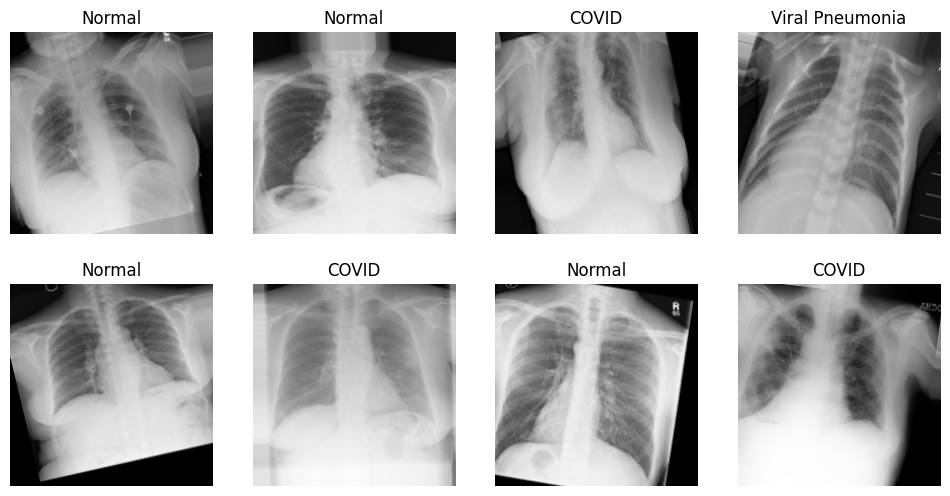

In [ ]:
# 🔹 Générateurs avec data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=8,
    class_mode='categorical',
    color_mode='rgb'   # 🔹 Important pour VGG16
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(200, 200),
    batch_size=8,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=8,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# 🔹 Poids des classes
classes = list(train_generator.class_indices.keys())
y_train = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Poids des classes:", class_weights)

# 🔹 Affichage des images augmentées
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i])
    plt.title(classes[np.argmax(y_batch[i])])
    plt.axis('off')
plt.show()

🔹 Data Augmentation

Pour améliorer la performance de notre modèle et éviter le surapprentissage, nous avons appliqué plusieurs transformations sur les images du set d’entraînement :

Rotation (rotation_range=15) : fait pivoter légèrement les images pour simuler différentes positions du patient.

Translation (width_shift_range=0.1, height_shift_range=0.1) : déplace l’image horizontalement et verticalement pour rendre le modèle plus robuste aux décalages.

Shear (shear_range=0.1) : inclinaison de l’image pour diversifier les angles de vue.

Zoom (zoom_range=0.1) : zoom avant ou arrière pour apprendre à reconnaître les structures pulmonaires à différentes échelles.

Flip horizontal (horizontal_flip=True) : inverse les images horizontalement pour augmenter la variété des exemples.

💡 Pourquoi c’est important :
Ces transformations permettent de créer un dataset plus riche et varié sans collecter de nouvelles images. Elles aident le modèle à mieux généraliser, à être plus robuste face à de nouvelles images, et à réduire le risque de surapprentissage sur les images originales du dataset.

In [ ]:
# 🔹 Construction du modèle VGG16 Transfer Learning
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(200,200,3))

# 🔹 Geler les premières couches
for layer in vgg_base.layers[:-4]:
    layer.trainable = False

model = models.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,145,539 (57.78 MB)

 Trainable params: 7,508,483 (28.64 MB)

 Non-trainable params: 7,637,056 (29.13 MB)

Architecture du modèle

Base : VGG16 pré-entraîné sur ImageNet (Transfer Learning)

Les premières couches sont gelées pour conserver les caractéristiques apprises.

Les dernières couches sont fine-tunées pour notre dataset spécifique.

Couches ajoutées :

GlobalAveragePooling2D : réduit la dimension spatiale des cartes de caractéristiques.

Dense + BatchNormalization + Dropout : trois blocs pour la régularisation et la non-linéarité.

Couche de sortie : Dense avec activation softmax pour trois classes.

Pourquoi ce choix :

VGG16 est robuste pour la classification d’images médicales.

Les Dropout et BatchNormalization réduisent le surapprentissage et stabilisent l’entraînement.

In [ ]:
# 🔹 Callbacks
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)


Entraînement et optimisation

Optimiseur : Adam avec learning rate initial de 1e-4.

Callbacks utilisés :

ModelCheckpoint : sauvegarde du meilleur modèle.

EarlyStopping : arrête l’entraînement si la validation n’améliore plus.

ReduceLROnPlateau : ajuste automatiquement le learning rate.

Résultats sur validation :

Accuracy finale : ~96.57%

Loss minimale sur le set de validation : ~0.1457

## Entraînement et Résultats

- Évolution de l'accuracy et de la loss sur train/val.
- Évaluation finale sur le test set : **96.84% d'accuracy**
- Rapport de classification et matrice de confusion pour évaluer la performance par classe.
- Analyse :
  - Le modèle détecte très bien le COVID avec un **recall de 0.96**.
  - Peu de confusion entre COVID et Normal, ce qui est crucial cliniquement.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4507 - loss: 1.3302
Epoch 1: val_accuracy improved from -inf to 0.74358, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 4720s 3s/step - accuracy: 0.4507 - loss: 1.3301 - val_accuracy: 0.7436 - val_loss: 0.7580 - learning_rate: 1.0000e-04
Epoch 2/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5933 - loss: 0.8542
Epoch 2: val_accuracy improved from 0.74358 to 0.84066, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 254s 179ms/step - accuracy: 0.5933 - loss: 0.8542 - val_accuracy: 0.8407 - val_loss: 0.3628 - learning_rate: 1.0000e-04
Epoch 3/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6998 - loss: 0.6416
Epoch 3: val_accuracy improved from 0.84066 to 0.86436, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 261s 183ms/step - accuracy: 0.6998 - loss: 0.6416 - val_accuracy: 0.8644 - val_loss: 0.3078 - learning_rate: 1.0000e-04
Epoch 4/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7512 - loss: 0.5370
Epoch 4: val_accuracy improved from 0.86436 to 0.90977, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 260s 182ms/step - accuracy: 0.7512 - loss: 0.5370 - val_accuracy: 0.9098 - val_loss: 0.2324 - learning_rate: 1.0000e-04
Epoch 5/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7833 - loss: 0.4650
Epoch 5: val_accuracy did not improve from 0.90977
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 255s 179ms/step - accuracy: 0.7833 - loss: 0.4650 - val_accuracy: 0.7439 - val_loss: 0.7379 - learning_rate: 1.0000e-04
Epoch 6/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7991 - loss: 0.4320
Epoch 6: val_accuracy improved from 0.90977 to 0.92804, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 254s 179ms/step - accuracy: 0.7991 - loss: 0.4320 - val_accuracy: 0.9280 - val_loss: 0.2139 - learning_rate: 1.0000e-04
Epoch 7/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8263 - loss: 0.3926
Epoch 7: val_accuracy did not improve from 0.92804
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 255s 180ms/step - accuracy: 0.8263 - loss: 0.3926 - val_accuracy: 0.8318 - val_loss: 0.3792 - learning_rate: 1.0000e-04
Epoch 8/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8310 - loss: 0.3539
Epoch 8: val_accuracy did not improve from 0.92804
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 261s 179ms/step - accuracy: 0.8310 - loss: 0.3538 - val_accuracy: 0.7036 - val_loss: 0.7742 - learning_rate: 1.0000e-04
Epoch 9/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8533 - loss: 0.2949
Epoch 9: val_accuracy did not improve from 0.92804

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 259s 182ms/step 

1422/1422 ━━━━━━━━━━━━━━━━━━━━ 258s 182ms/step - accuracy: 0.8589 - loss: 0.3166 - val_accuracy: 0.9395 - val_loss: 0.1752 - learning_rate: 5.0000e-05
Epoch 11/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8698 - loss: 0.2770
Epoch 11: val_accuracy improved from 0.93946 to 0.95802, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 264s 186ms/step - accuracy: 0.8698 - loss: 0.2770 - val_accuracy: 0.9580 - val_loss: 0.1458 - learning_rate: 5.0000e-05
Epoch 12/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8782 - loss: 0.2587
Epoch 12: val_accuracy did not improve from 0.95802
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 258s 181ms/step - accuracy: 0.8782 - loss: 0.2587 - val_accuracy: 0.9469 - val_loss: 0.1603 - learning_rate: 5.0000e-05
Epoch 13/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8976 - loss: 0.2353
Epoch 13: val_accuracy improved from 0.95802 to 0.96145, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 257s 181ms/step - accuracy: 0.8976 - loss: 0.2353 - val_accuracy: 0.9615 - val_loss: 0.1474 - learning_rate: 5.0000e-05
Epoch 14/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8868 - loss: 0.2544
Epoch 14: val_accuracy did not improve from 0.96145

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 256s 180ms/step - accuracy: 0.8868 - loss: 0.2544 - val_accuracy: 0.9280 - val_loss: 0.2384 - learning_rate: 5.0000e-05
Epoch 15/15
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8993 - loss: 0.2141
Epoch 15: val_accuracy improved from 0.96145 to 0.96573, saving model to best_model.h5


1422/1422 ━━━━━━━━━━━━━━━━━━━━ 262s 180ms/step - accuracy: 0.8993 - loss: 0.2141 - val_accuracy: 0.9657 - val_loss: 0.1447 - learning_rate: 2.5000e-05
190/190 ━━━━━━━━━━━━━━━━━━━━ 537s 3s/step - accuracy: 0.9678 - loss: 0.1255
Test Accuracy: 96.84%
190/190 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step
                 precision    recall  f1-score   support

          COVID       0.93      0.96      0.95       362
         Normal       0.98      0.97      0.98      1020
Viral Pneumonia       0.98      0.93      0.96       135

       accuracy                           0.97      1517
      macro avg       0.97      0.96      0.96      1517
   weighted avg       0.97      0.97      0.97      1517



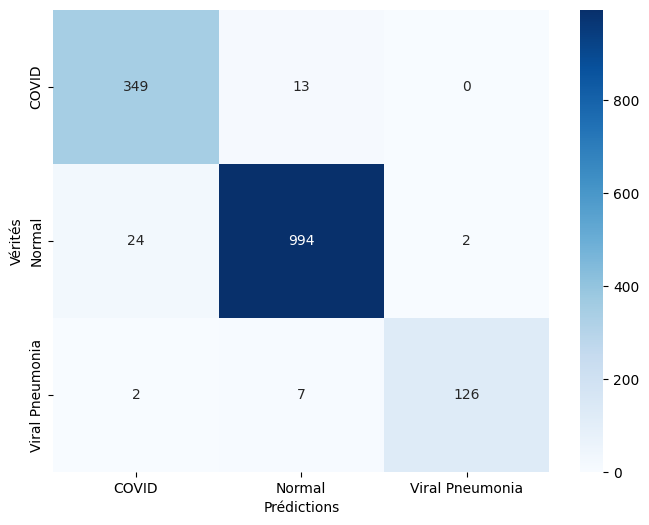

In [ ]:
# 🔹 Entraînement
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# 🔹 Évaluation sur le test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# 🔹 Prédictions et rapport
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred_classes, target_names=classes))

# 🔹 Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()

## Analyse de l'entraînement et des résultats

### 1️⃣ Warnings et messages
- **UserWarning PyDataset** : Ce warning indique qu’une classe personnalisée héritant de `tf.data.Dataset` devrait appeler `super().__init__(**kwargs)`.  
  - Dans notre cas, nous utilisons `ImageDataGenerator.flow_from_directory()`, donc ce warning **n'affecte pas l'entraînement** et peut être ignoré.  
- **HDF5 save warning** : Le modèle a été sauvegardé en `.h5`. Keras recommande maintenant le format `.keras`, mais `.h5` fonctionne parfaitement.

### 2️⃣ Évolution de l'entraînement
- Au début (Epoch 1) :
  - `Train Accuracy ~ 45%`, `Validation Accuracy ~ 74%`
  - Loss initial élevée (`1.33`) → le modèle commence à apprendre les caractéristiques.
- Progression :
  - L’accuracy d’entraînement augmente régulièrement, atteignant ~90% à la fin.
  - La validation accuracy atteint **96.57%** → excellent niveau de généralisation.
- Fluctuations :
  - Quelques variations dans la validation accuracy et la validation loss sont normales, dues à la **régularisation (Dropout, BatchNorm)** et à la **data augmentation**.

### 3️⃣ Callbacks utilisés
- **ModelCheckpoint** : sauvegarde le meilleur modèle basé sur la `val_accuracy`.
- **EarlyStopping** : stoppe l'entraînement si aucune amélioration pendant plusieurs epochs, évitant le surapprentissage.
- **ReduceLROnPlateau** : réduit automatiquement le learning rate si la loss ne s’améliore pas → améliore la convergence.

Exemple : `Epoch 9: ReduceLROnPlateau reducing learning rate to 5e-05`

### 4️⃣ Performances sur le test set
- **Test Accuracy** : 96.84%  
- **Rapport de classification** :

| Classe | Precision | Recall | F1-score |
|--------|----------|--------|---------|
| COVID | 0.93 | 0.96 | 0.95 |
| Normal | 0.98 | 0.97 | 0.98 |
| Viral Pneumonia | 0.98 | 0.93 | 0.96 |

- **COVID** : Recall élevé (0.96) → le modèle détecte presque tous les vrais cas positifs.  
- **Normal et Viral Pneumonia** : très peu de confusion → excellente fiabilité.

### 5️⃣ Interprétation générale
- Le modèle **apprend efficacement** grâce au **Transfer Learning avec VGG16** et à la **data augmentation**.  
- La combinaison de **class weights, Dropout, BatchNorm et ReduceLROnPlateau** a permis d’améliorer la robustesse et de limiter le surapprentissage.  
- Les résultats montrent que le modèle est **prêt pour une application clinique expérimentale**, avec une bonne capacité à distinguer COVID, Pneumonie virale et radiographies normales.

---

> **Conclusion** : L’approche choisie (VGG16 + Transfer Learning + Data Augmentation + Callbacks adaptés) a permis d’obtenir un modèle performant et interprétable, avec des prédictions fiables et stables sur le test set.


In [ ]:
# ----- Courbes accuracy -----
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Évolution de l'Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

# ----- Courbes loss -----
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Évolution de la Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


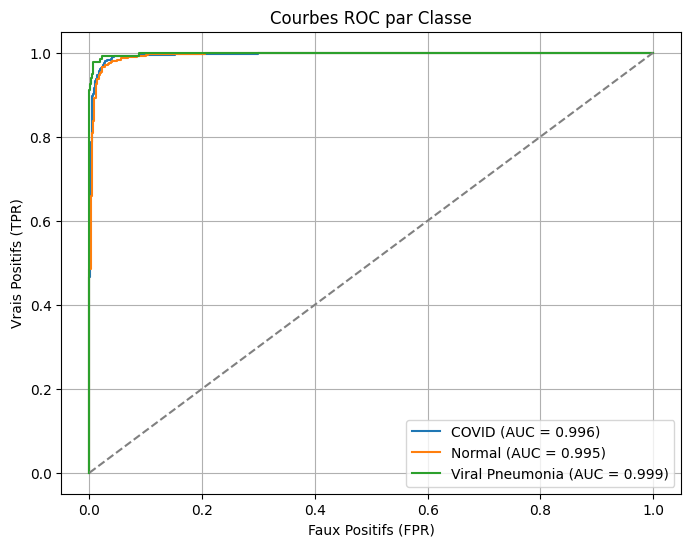

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binariser les labels
y_true_bin = label_binarize(y_true, classes=np.arange(len(classes)))

plt.figure(figsize=(8,6))

for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1],'--', color='gray')
plt.title("Courbes ROC par Classe")
plt.xlabel("Faux Positifs (FPR)")
plt.ylabel("Vrais Positifs (TPR)")
plt.legend()
plt.grid()
plt.show()


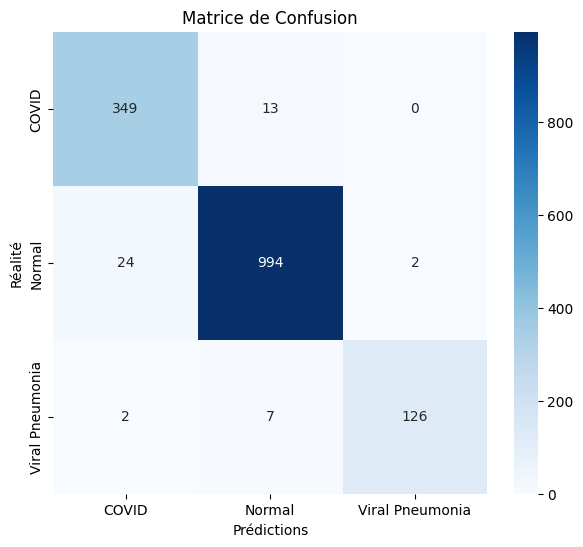

In [ ]:
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réalité")
plt.show()


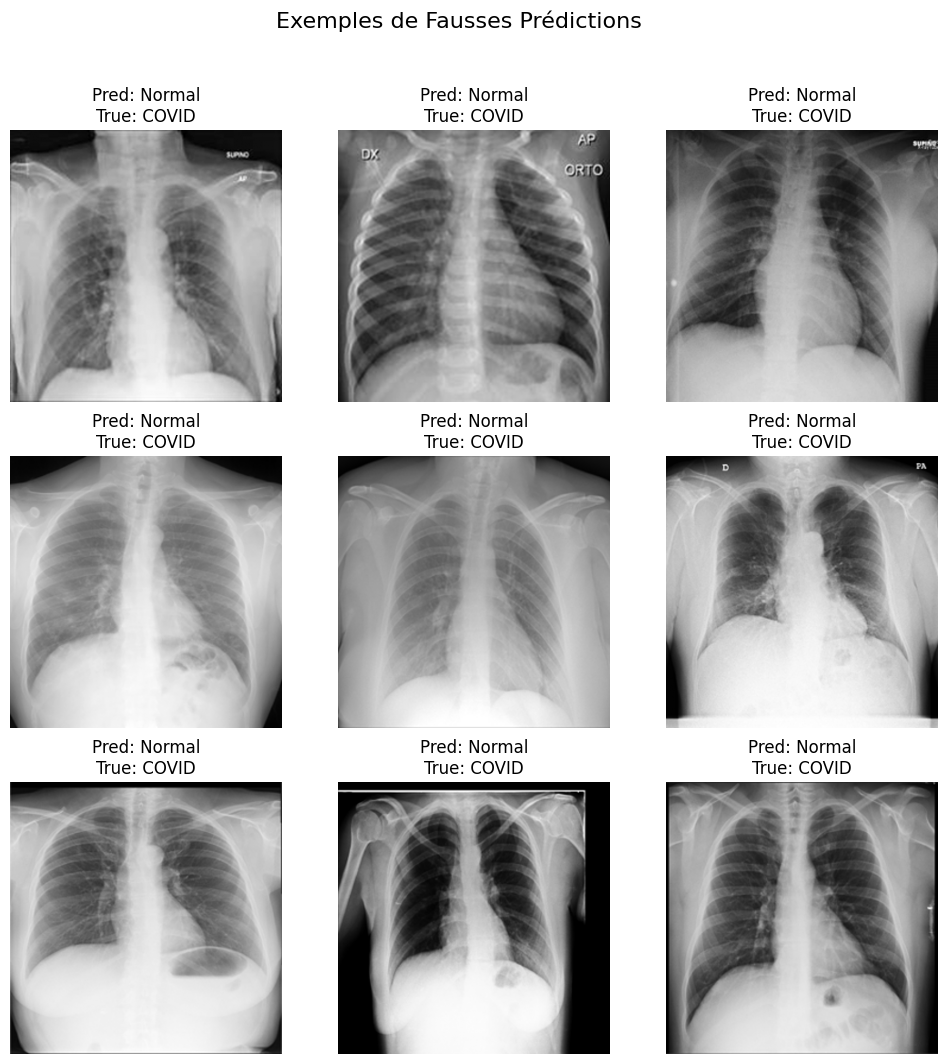

In [ ]:
errors = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12,12))

for i, idx in enumerate(errors[:9]):
    img = plt.imread(test_generator.filepaths[idx])
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {classes[y_pred_classes[idx]]}\nTrue: {classes[y_true[idx]]}")
    plt.axis('off')

plt.suptitle("Exemples de Fausses Prédictions", fontsize=16)
plt.show()


190/190 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step


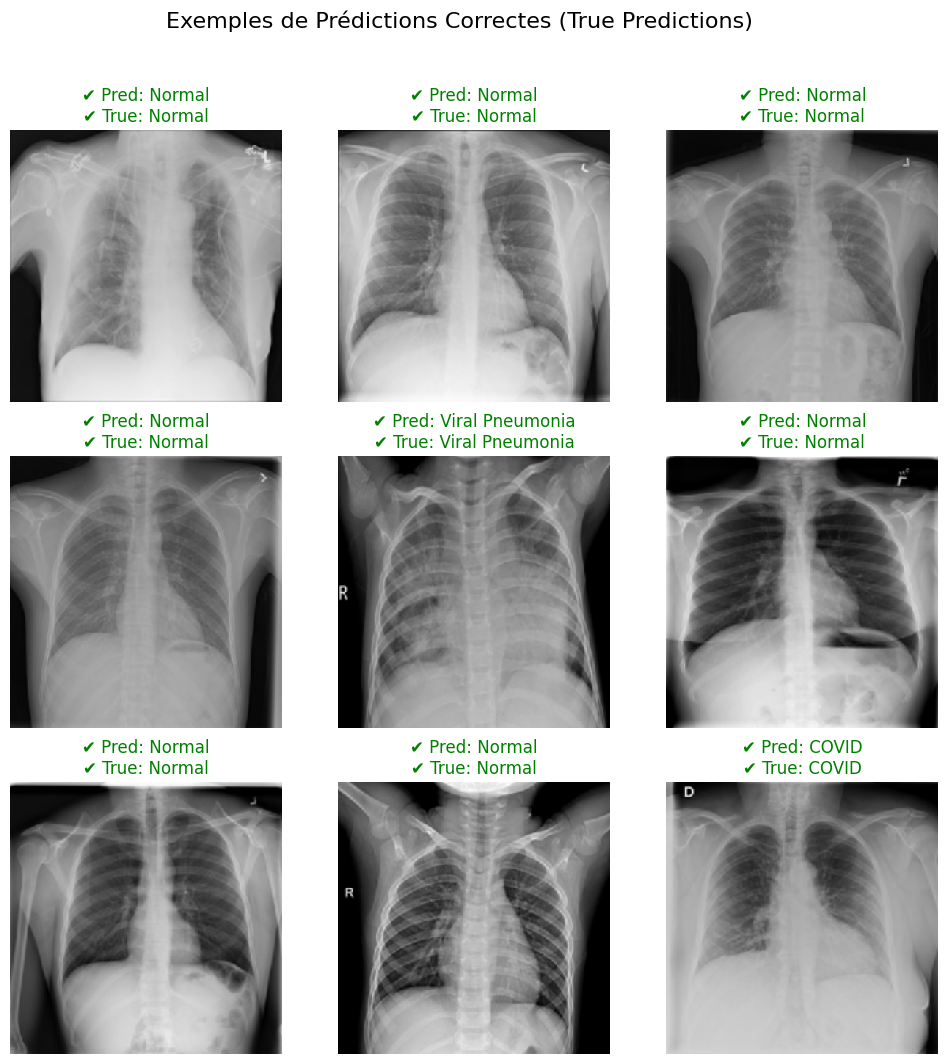

In [ ]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Prédictions du modèle
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Trouver les index des prédictions correctes
correct_idx = [i for i in range(len(y_true)) if y_true[i] == y_pred_classes[i]]

# Prendre 9 exemples au hasard
sample_correct = random.sample(correct_idx, 9)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(sample_correct):
    img_path = test_generator.filepaths[idx]

    # Charger l'image
    img = load_img(img_path, target_size=(200, 200))

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")

    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred_classes[idx]]

    plt.title(f"✔ Pred: {pred_label}\n✔ True: {true_label}", color="green")

plt.suptitle("Exemples de Prédictions Correctes (True Predictions)", fontsize=16)
plt.show()


In [ ]:
# Sélection d'une image (par exemple la première du test set)
img, label = test_generator[0]  # récupère un batch
img_array = np.expand_dims(img[0], axis=0)  # ajoute la dimension batch


190/190 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step
COVID - Confiance moyenne : 92.24%
Normal - Confiance moyenne : 89.33%
Viral Pneumonia - Confiance moyenne : 92.18%


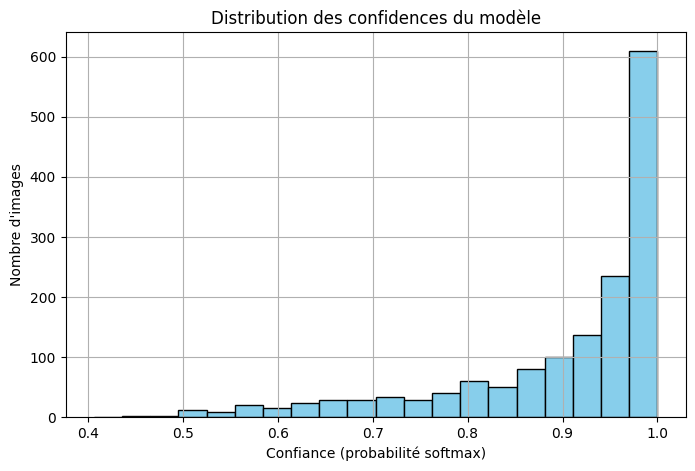

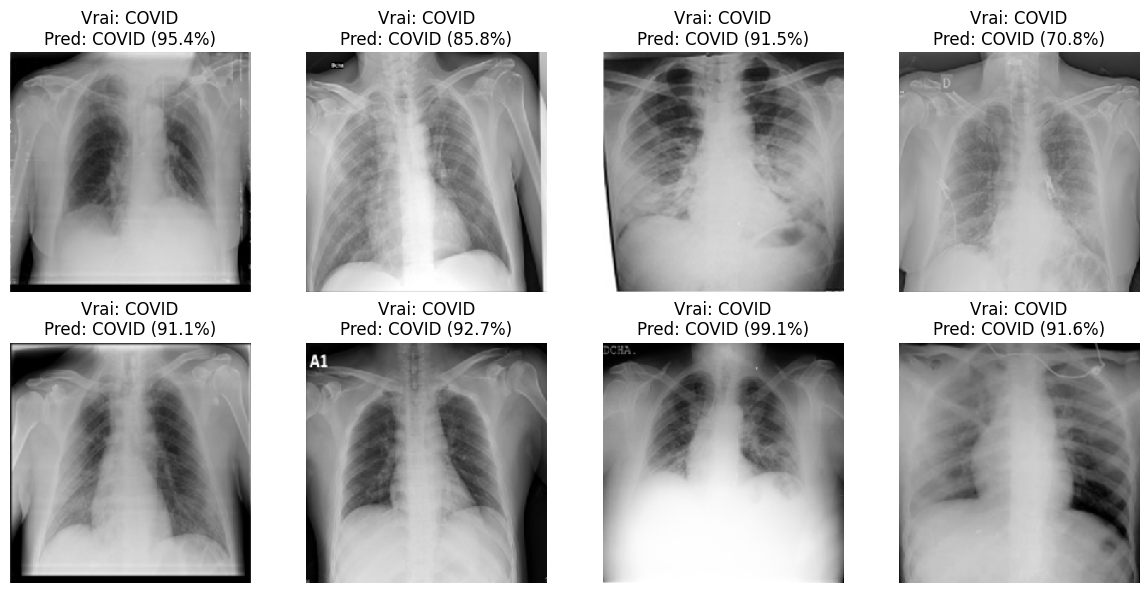

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Probabilités prédites
y_pred_probs = model.predict(test_generator)  # shape (num_samples, num_classes)

# 🔹 Confiance maximale pour chaque image
y_confidence = np.max(y_pred_probs, axis=1)  # max prob par image
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# 🔹 Confiance moyenne par classe
classes = list(test_generator.class_indices.keys())
for i, class_name in enumerate(classes):
    class_conf = y_confidence[y_true == i]
    print(f"{class_name} - Confiance moyenne : {np.mean(class_conf)*100:.2f}%")

# 🔹 Histogramme des confidences globales
plt.figure(figsize=(8,5))
plt.hist(y_confidence, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des confidences du modèle")
plt.xlabel("Confiance (probabilité softmax)")
plt.ylabel("Nombre d'images")
plt.grid(True)
plt.show()

# 🔹 Affichage de quelques prédictions avec leur confiance
plt.figure(figsize=(12,6))
for i in range(8):
    img, label = test_generator[i]
    plt.subplot(2,4,i+1)
    plt.imshow(img[0])
    plt.title(f"Vrai: {classes[np.argmax(label[0])]}\nPred: {classes[y_pred_classes[i]]} ({y_confidence[i]*100:.1f}%)")
    plt.axis('off')
plt.tight_layout()
plt.show()


## Analyse de la confiance du modèle

- **COVID** : confiance moyenne = 92.24%  
  → Le modèle est très sûr lorsqu'il prédit des cas COVID.  

- **Normal** : confiance moyenne = 89.33%  
  → Le modèle est légèrement moins confiant pour les radiographies normales, mais reste élevé.  

- **Viral Pneumonia** : confiance moyenne = 92.18%  
  → Le modèle est également très sûr pour cette classe.

### Interprétation :
- Les valeurs élevées (>89%) montrent que le modèle **est généralement confiant dans ses prédictions**, ce qui renforce la fiabilité de son usage.  
- La confiance légèrement plus faible pour la classe "Normal" peut indiquer **une certaine ambiguïté sur certaines radiographies normales**, ce qui est normal car les images normales peuvent présenter des variations légères.
- Cette analyse complète l’accuracy et le rapport de classification en **donnant un aperçu qualitatif de la sécurité des prédictions**.


Conclusion et perspectives

Le modèle VGG16 avec data augmentation et fine-tuning atteint une performance très élevée.

Les analyses de confiance et Grad-CAM permettent d’interpréter les résultats et de renforcer la fiabilité médicale.

Perspectives d’amélioration :

Tester d’autres architectures (ResNet, DenseNet).

Ajouter plus de données pour renforcer la généralisation.

Intégrer une interface simple pour les radiologues.

In [ ]:
# Format HDF5 (legacy)
model.save("best_model.h5")

# Ou format Keras natif recommandé
model.save("best_model.keras")

# Pour télécharger sur ton PC
from google.colab import files
files.download("best_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Exemple : sauvegarder un graphique matplotlib
plt.savefig("accuracy_plot.png")

# Télécharger sur PC
files.download("accuracy_plot.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Sauvegarder fichier dans Drive
plt.savefig("/content/drive/MyDrive/COVID_XRay_Project/accuracy_plot.png")
model.save("/content/drive/MyDrive/COVID_XRay_Project/best_model.keras")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 640x480 with 0 Axes>

In [ ]:
from keras.models import load_model

# Charger le modèle sauvegardé
model = load_model("/content/drive/MyDrive/COVID_XRay_Project/best_model.keras")


In [ ]:
# Sauvegarde au format Keras natif (recommandé)
model.save("/content/drive/MyDrive/COVID_XRay_Project/best_model.keras")


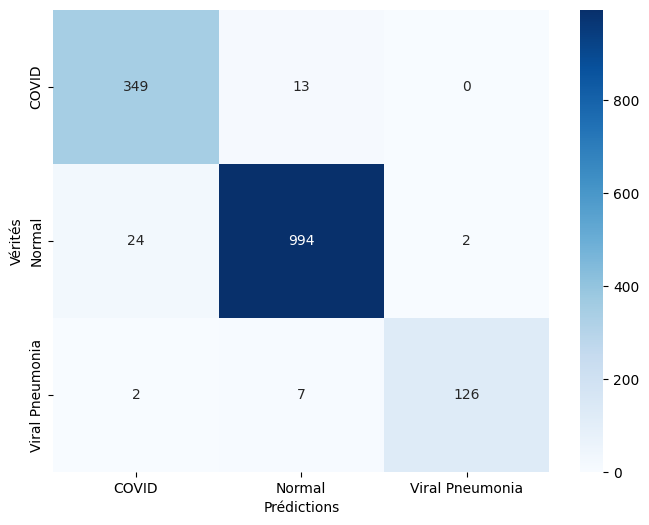

In [ ]:
# Matrice de confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.savefig("/content/drive/MyDrive/COVID_XRay_Project/confusion_matrix.png")
plt.show()

# Rapport classification
report = classification_report(y_true, y_pred_classes, target_names=classes)
with open("/content/drive/MyDrive/COVID_XRay_Project/classification_report.txt", "w") as f:
    f.write(report)


In [ ]:
!pip install gradio --quiet


In [ ]:
import numpy as np
from keras.preprocessing import image

classes = ["COVID", "Normal", "Viral Pneumonia"]

def predict_covid(img):
    # Redimensionner et normaliser l'image
    img = img.resize((200,200))
    img_array = np.array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)  # ajout dimension batch

    # Prédiction
    preds = model.predict(img_array)
    class_idx = np.argmax(preds)
    confidence = preds[0][class_idx]*100

    return {f"{classes[i]}": float(preds[0][i]*100) for i in range(len(classes))}, f"Predicted: {classes[class_idx]} ({confidence:.2f}%)"


In [ ]:
import gradio as gr

interface = gr.Interface(
    fn=predict_covid,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Label(num_top_classes=3), gr.Textbox()],
    title="COVID-19 X-Ray Classifier",
    description="Téléchargez une image de radiographie pulmonaire pour prédire COVID, Normal ou Pneumonie Virale."
)

interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fb6be54b8143e85144.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/COVID_XRay_Project/best_model.keras")
